In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.patches import Circle

In [2]:
def sample_smiley(n_eyes=500, n_mouth=1000, seed=0):
    rng = np.random.default_rng(seed)

    # Eyes: two Gaussian blobs
    eye_sigma = 0.05
    left_eye_center  = np.array([-0.6, 0.6])
    right_eye_center = np.array([ 0.6, 0.6])

    left_eye  = left_eye_center  + rng.normal(scale=eye_sigma, size=(n_eyes, 2))
    right_eye = right_eye_center + rng.normal(scale=eye_sigma, size=(n_eyes, 2))
    
    # Mouth: noisy arc of a circle (smiling)
    R = 1.1
    mouth_y = 0.8
    theta = rng.uniform(low=0.15*np.pi, high=0.85*np.pi, size=n_mouth)

    x_mouth = R * np.cos(theta)
    y_mouth = mouth_y - 0.6 - R * np.sin(theta)  # <-- flipped sign for a smile

    mouth_noise = rng.normal(scale=0.03, size=(n_mouth, 2))
    mouth = np.stack([x_mouth, y_mouth], axis=1) + mouth_noise

    points = np.vstack([left_eye, right_eye, mouth])
    return points

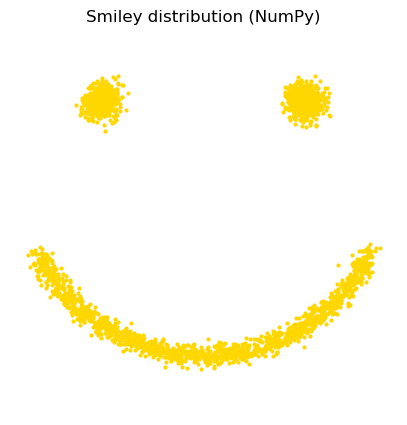

In [3]:
# Generate and plot
pts = sample_smiley(n_eyes=600, n_mouth=1500, seed=42)

plt.figure(figsize=(5,5))
plt.scatter(pts[:,0], pts[:,1], s=4, color='gold')
plt.axis('equal')
plt.axis('off')
plt.title("Smiley distribution (NumPy)")
plt.show()


In [14]:
def make_beta_schedule(T=1000, schedule="linear", beta_start=1e-4, beta_end=0.02, device="cpu"):
    if schedule == "linear":
        betas = torch.linspace(beta_start, beta_end, T, device=device)
    elif schedule == "cosine":
        # Nichol & Dhariwal cosine schedule
        s = 0.008
        t = torch.linspace(0, T, T+1, device=device) / T
        alphas_bar = torch.cos((t + s) / (1 + s) * torch.pi / 2) ** 2
        alphas_bar = alphas_bar / alphas_bar[0]
        betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
        betas = betas.clamp(1e-8, 0.999)
    else:
        raise ValueError("Unknown schedule")
    return betas

@torch.no_grad()
def q_sample(x0, t, alphas_bar, noise=None):
    """
    Closed-form noising: x_t = sqrt(alphas_bar[t]) * x0 + sqrt(1 - alphas_bar[t]) * eps
    x0: (N, D)
    t: scalar int or (N,) with step indices in [0, T-1]
    """
    if noise is None:
        noise = torch.randn_like(x0)
    # Gather \bar{alpha}_t per sample
    if t.ndim == 0:
        a_bar_t = alphas_bar[t].view(1, 1)
    else:
        a_bar_t = alphas_bar[t].view(-1, 1)
    return torch.sqrt(a_bar_t) * x0 + torch.sqrt(1.0 - a_bar_t) * noise

# Example: apply to your NumPy-generated smiley points
def torch_forward_noising(smiley_pts_np, T=1000, steps_to_show=(0, 50, 200, 500, 999), device="cpu"):
    x0 = torch.tensor(smiley_pts_np, dtype=torch.float32, device=device)  # shape (N,2)
    betas = make_beta_schedule(T=T, schedule="cosine", device=device)
    alphas = 1.0 - betas
    alphas_bar = torch.cumprod(alphas, dim=0)  # (T,)

    xs = {}
    for s in steps_to_show:
        xt = q_sample(x0, torch.tensor(s, device=device), alphas_bar)
        xs[int(s)] = xt.cpu().numpy()
    return xs  # dict: step -> (N,2) noisy points


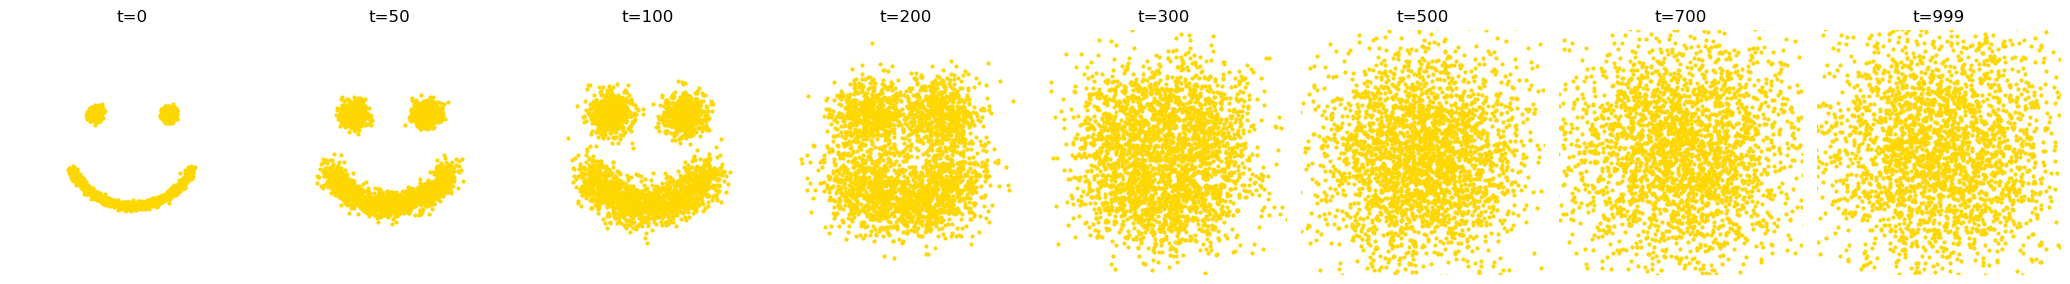

In [29]:
def plot_side_by_side(xs, color="gold", s=4):
    # xs: dict {t -> (N,2) array}; t can be ints like 0, 50, 200...
    steps = sorted(xs.keys())

    # Use shared limits so the geometry is comparable across t
    all_pts = np.vstack([xs[t] for t in steps])
    x_min, x_max = np.percentile(all_pts[:,0], [1, 99])
    y_min, y_max = np.percentile(all_pts[:,1], [1, 99])
    pad_x = 0.05 * (x_max - x_min + 1e-8)
    pad_y = 0.05 * (y_max - y_min + 1e-8)
    xlim = (x_min - pad_x, x_max + pad_x)
    ylim = (y_min - pad_y, y_max + pad_y)

    fig, axs = plt.subplots(1, len(steps), figsize=(2.6*len(steps), 3))
    if len(steps) == 1:
        axs = [axs]  # ensure iterable

    for ax, t in zip(axs, steps):
        arr = xs[t]
        ax.scatter(arr[:,0], arr[:,1], s=s, color=color)
        ax.set_title(f"t={t}")
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        ax.set_aspect("equal", adjustable="box")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
xs = torch_forward_noising(pts, T=1_000, steps_to_show=(0, 50, 100, 200, 300, 500, 700, 999))
plot_side_by_side(xs)

In [56]:
def plot_ddpm_transition_stats_and_trajectories_2d(
    x0,
    betas,
    n_traj=10,
    seed=0,
    *,
    circle_alpha=0.20,
    circle_lw=1.0,
    mean_marker_size=60,
    traj_lw=1.2,
    traj_alpha=0.6,
    show_traj_points=False,
    traj_point_size=8,
    figsize=(7, 7),
):
    """
    Plots DDPM forward transition-kernel statistics at x_{t-1}=x0 for each beta_t:
        q(x_t | x_{t-1}=x0) = N( sqrt(1-beta_t) * x0, beta_t I )

    Additionally overlays n_traj random forward trajectories sampled from:
        x_t = sqrt(1-beta_t) * x_{t-1} + sqrt(beta_t) * eps_t, eps_t ~ N(0, I)

    Args:
        x0: array-like shape (2,)
        betas: array-like shape (T,), each in (0,1)
        n_traj: number of random trajectories to simulate
        seed: RNG seed
        circle_alpha: transparency for std circles
        circle_lw: line width for circles
        mean_marker_size: size for mean 'x' markers
        traj_lw: line width for trajectories
        traj_alpha: transparency for trajectories
        show_traj_points: scatter trajectory intermediate points if True
        traj_point_size: point size if show_traj_points
        figsize: figure size
    Returns:
        means: (T,2) array of mu_t = sqrt(1-beta_t) * x0
        sigmas: (T,) array of sigma_t = sqrt(beta_t)
        trajs: (n_traj, T+1, 2) array of sampled trajectories including x0 at index 0
    """
    x0 = np.asarray(x0, dtype=float).reshape(2)
    betas = np.asarray(betas, dtype=float).reshape(-1)
    T = betas.shape[0]

    if np.any(betas <= 0) or np.any(betas >= 1):
        raise ValueError("All betas must be in (0, 1).")

    # Transition stats evaluated at x_{t-1} = x0 (as requested)
    sigmas = np.sqrt(betas)
    means = (np.sqrt(1.0 - betas)[:, None] * x0[None, :])  # (T,2)

    # Sample trajectories
    rng = np.random.default_rng(seed)
    trajs = np.zeros((n_traj, T + 1, 2), dtype=float)
    trajs[:, 0, :] = x0

    for k in range(n_traj):
        x = x0.copy()
        for t, beta in enumerate(betas, start=1):
            eps = rng.normal(0.0, 1.0, size=2)
            x = np.sqrt(1.0 - beta) * x + np.sqrt(beta) * eps
            trajs[k, t, :] = x

    # Plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot transition means and std circles
    for mu, sigma in zip(means, sigmas):
        ax.scatter(mu[0], mu[1], marker="x", s=mean_marker_size, color="C0")
        ax.add_patch(Circle(mu, radius=sigma, fill=False, edgecolor="C1",
                            alpha=circle_alpha, linewidth=circle_lw))

    # Plot x0


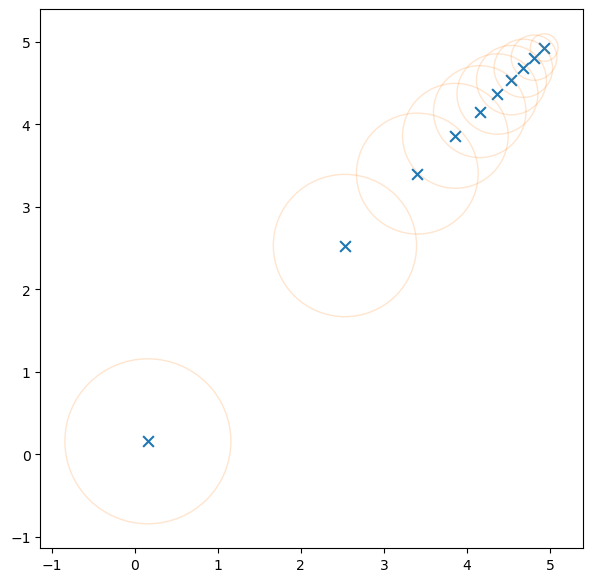

In [58]:
plot_ddpm_transition_stats_and_trajectories_2d([5., 5.], betas=make_beta_schedule(10, beta_end=0.999999, schedule='cosine'))